In [115]:
import pandas as pd
from fractions import Fraction
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter, LogLocator, FuncFormatter
import seaborn as sns
import numpy as np
from collections import Counter
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import tqdm as notebook_tqdm
import gensim
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from itertools import cycle
import hashlib

In [3]:
# Read the two CSV files
df_part1 = pd.read_csv('processed_data_part1.csv')
df_part2 = pd.read_csv('processed_data_part2.csv')

# Concatenate the two DataFrames
df = pd.concat([df_part1, df_part2], ignore_index=True)

pd.set_option('display.max_colwidth', None)
df.head(2)

,PMID,Title,Abstract,Authors,Publication Date,DOI,Abstract_Length
0,24645995,α-1 antitrypsin and chronic fatigue syndrome: a case study from pathophysiology to clinical practice.,SUMMARY Several lines of evidence support the involvement of inflammatory and immunologic abnormalities in chronic fatigue syndrome CFS Since recent studies have shown that α1 antitrypsin AAT possesses antiinflammatory properties the potential therapeutic effect of AAT treatment on CFS has been investigated A 49yearold woman diagnosed with CFS was treated with intravenous infusions of a human plasmaderived AAT concentrate 60 mgkg body weight weekly for 8 consecutive weeks The patients monocyte elastase a regulator of inflammatory processes was 1170 Umg At completion of treatment improvement in maximal workload was observed 540717 of predicted Additionally amelioration in working memory scores 8394 and perceptual organization scores 7583 were detected on the Wechsler Adult Intelligence ScaleIII test Monocyte elastase decreased to a normal range 150 Umg Improvement in functional capacity allowed the patient to work in parttime employment These findings suggest a possible role for AAT in the treatment of CFS,Jose Alegre; Sandra Camprubi; Ana GarciaQuintana,2013-Mar,10.2217/pmt.12.84,1020
1,24565439,A data-driven acute inflammation therapy.,Acute inflammation is a severe medical condition defined as an inflammatory response of the body to an infection Its rapid progression requires quick and accurate decisions from clinicians Inadequate and delayed decisions makes acute inflammation the 10th leading cause of death overall in United States with the estimated cost of treatment about 17 billion annually However despite the need there are limited number of methods that could assist clinicians to determine optimal therapies for acute inflammation We developed a datadriven method for suggesting optimal therapy by using machine learning model that is learned on historical patients behaviors To reduce both the risk of failure and the expense for clinical trials our method is evaluated on a virtual patients generated by a mathematical model that emulates inflammatory response In conducted experiments acute inflammation was handled with two complimentary pro and antiinflammatory medications which adequate timing and doses are crucial for the successful outcome Our experiments show that the dosage regimen assigned with our datadriven method significantly improves the percentage of healthy patients when compared to results by other methods used in clinical practice and found in literature Our method saved 88 of patients that would otherwise die within a week while the best method found in literature saved only 73 of patients At the same time our method used lower doses of medications than alternatives In addition our method achieved better results than alternatives when only incomplete or noisy measurements were available over time as well as it was less affected by therapy delay The presented results provide strong evidence that models from the artificial intelligence community have a potential for development of personalized treatment strategies for acute inflammation,Vladan Radosavljevic; Kosta Ristovski; Zoran Obradovic,2013,10.1186/1755-8794-6-S3-S7,1853


In [4]:
print(df.shape)
print(df.isnull().sum())  # Check for missing values
df.columns  # Check all column names 

(58535, 7)
PMID                0
Title               0
Abstract            0
Authors             0
Publication Date    0
DOI                 0
Abstract_Length     0
dtype: int64


Index(['PMID', 'Title', 'Abstract', 'Authors', 'Publication Date', 'DOI',
       'Abstract_Length'],
      dtype='object')

In [9]:
df['Abstract_Length'] = df['Abstract'].apply(len)

# Sort the DataFrame by the length of abstracts
df_sorted = df.sort_values('Abstract_Length')

# Display the shortest abstracts (abstracts can be shorter than 100 characters due to cleaning)
pd.set_option('display.max_colwidth', None)
df_sorted.head(3)

,PMID,Title,Abstract,Authors,Publication Date,DOI,Abstract_Length
23778,33671343,Changing Dental Profession-Modern Forms and Challenges in Dental Practice.,In the last two decades an increasing trend towards new forms of dental practice was observed,Thomas Gerhard Wolf; Guglielmo Campus,2021-Feb-17,10.3390/ijerph18041945,93
29343,34943534,"Special Issue ""Advances in Breast MRI"".",We thank all the authors reviewers and the editorial staff who contributed to this Special Issue,Francesca Galati; Rubina Manuela Trimboli; Federica Pediconi,2021-Dec-08,10.3390/diagnostics11122297,96
29169,34972694,Integrating artificial intelligence in bedside care for covid-19 and future pandemics.,bMichael Yu and colleaguesb examine the challenges in developing AI tools for use at point of care,Michael Yu; An Tang; Kip Brown; Rima Bouchakri; Pascal StOnge; Sheng Wu; John Reeder; Louis Mullie; Michael Chasse,2021-Dec-31,10.1136/bmj-2021-068197,98


In [7]:
# Minimum, Maximum, and Mean
min_length = df['Abstract_Length'].min()
max_length = df['Abstract_Length'].max()
mean_length = df['Abstract_Length'].mean()
std_dev_length = df['Abstract_Length'].std()

print(f"Minimum Abstract Length: {min_length}")
print(f"Maximum Abstract Length: {max_length}")
print(f"Average Abstract Length: {mean_length:.2f}")
print(f"Standard Deviation of Abstract Length: {std_dev_length:.2f}")


Minimum Abstract Length: 93
Maximum Abstract Length: 60664
Average Abstract Length: 1504.78
Standard Deviation of Abstract Length: 564.07


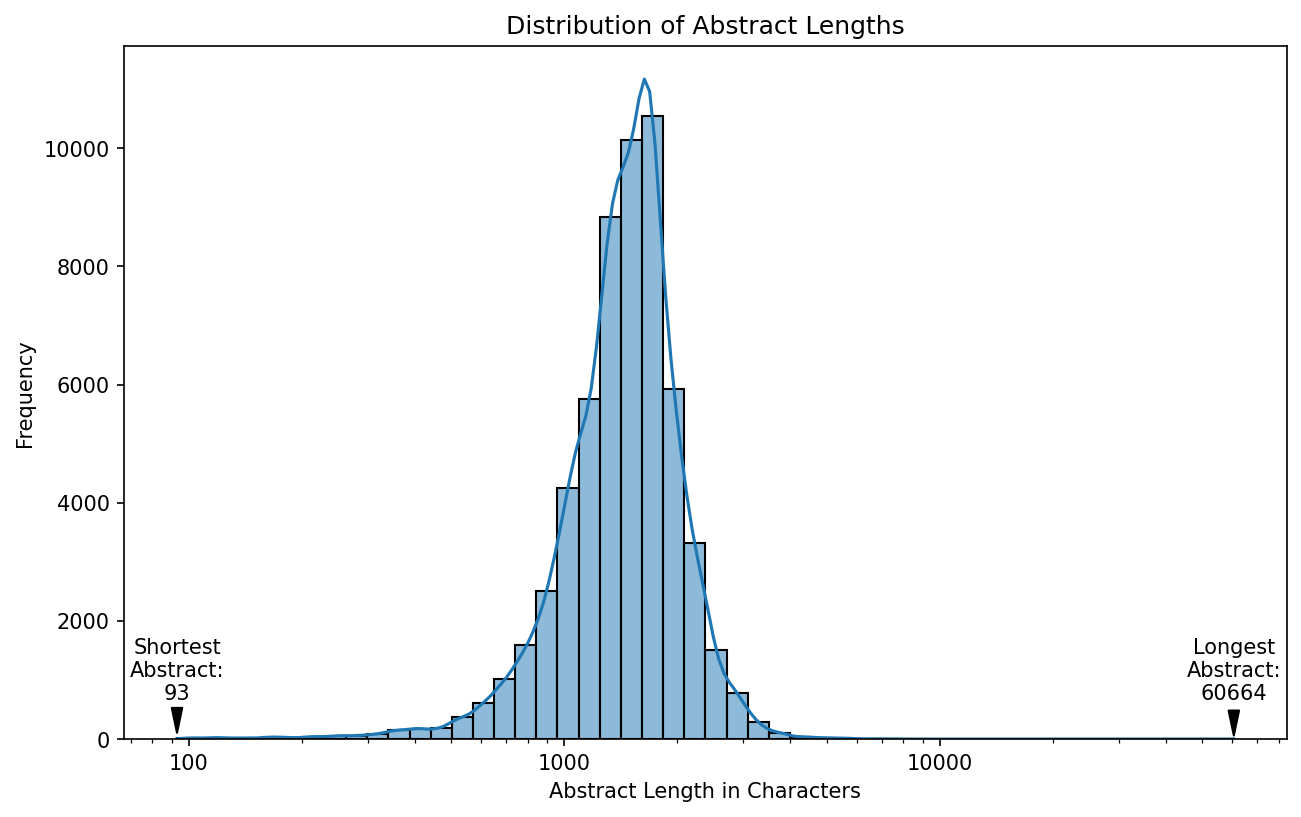

In [51]:
# Histogram of abstract lengths
plt.figure(figsize=(10, 6), dpi=150)
sns.histplot(df['Abstract_Length'], bins=50, kde=True, log_scale=(True, False))  # Nur X-Achse logarithmisch

# Name titles
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Abstract Length in Characters')
plt.ylabel('Frequency')

# LogFormatter verwenden, um die Achsenbeschriftungen anzupassen
formatter = LogFormatter(10, labelOnlyBase=False)
plt.gca().xaxis.set_major_formatter(formatter)

# Annotate the shortest abstract
plt.annotate(f'Shortest\nAbstract:\n93', xy=(93, 50), xytext=(93, 600),
             arrowprops=dict(facecolor='black', shrink=0.1, width=1, headwidth=5),
             horizontalalignment='center', verticalalignment='bottom')

# Annotate the longest abstract
plt.annotate(f'Longest\nAbstract:\n60664', xy=(60664, 0), xytext=(60664, 600),
             arrowprops=dict(facecolor='black', shrink=0.1,  width=1, headwidth=5),
             horizontalalignment='center', verticalalignment='bottom')

# Save plot
plt.savefig("../docs/images/distribution_abstract_length_log_scale.png")
plt.show()

In [60]:
df['Publication Date'][:10]

0       2013-Mar
1           2013
2           2013
3    2013-Jan-07
4           2013
5        Unknown
6           2013
7           2013
8           2013
9           2013
Name: Publication Date, dtype: object

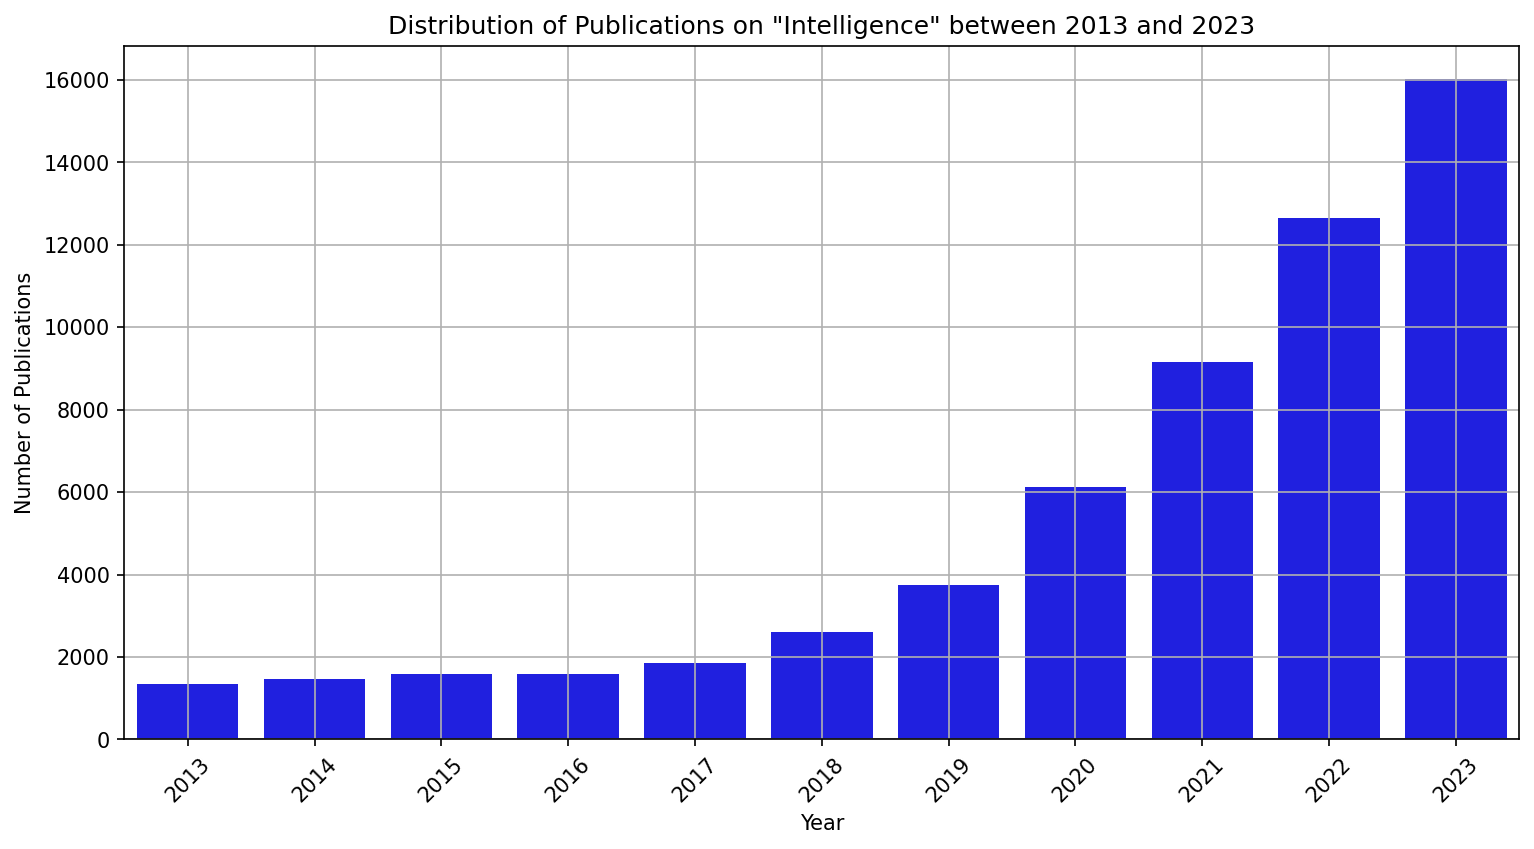

In [65]:
# Distribution of publications over the years
# Extract the year from the 'Publication Date' column
df['Year'] = df['Publication Date'].str.extract(r'(\d{4})')

# Remove rows with 'Unknown' or where the year couldn't be extracted
df = df[df['Year'].notnull() & (df['Year'] != 'Unknown')]

# Convert the year column to integers
df['Year'] = df['Year'].astype(int)

# Filter the DataFrame for years 2013 to 2023
df = df[(df['Year'] >= 2013) & (df['Year'] <= 2023)]

# Group by 'Year' and count the number of publications each year
publications_per_year = df.groupby('Year').size()
publications_per_year_df = publications_per_year.reset_index(name='Frequency')

# Plot the distribution of publications over the years as a bar chart
plt.figure(figsize=(12, 6), dpi=150)
sns.barplot(x='Year', y='Frequency', data=publications_per_year_df, color='blue')
plt.title('Distribution of Publications on "Intelligence" between 2013 and 2023')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)  # Rotate the x-axis labels to prevent overlap
plt.grid(True)

# Save plot
plt.savefig("../docs/images/distribution_publications_over_time.png")
plt.show()

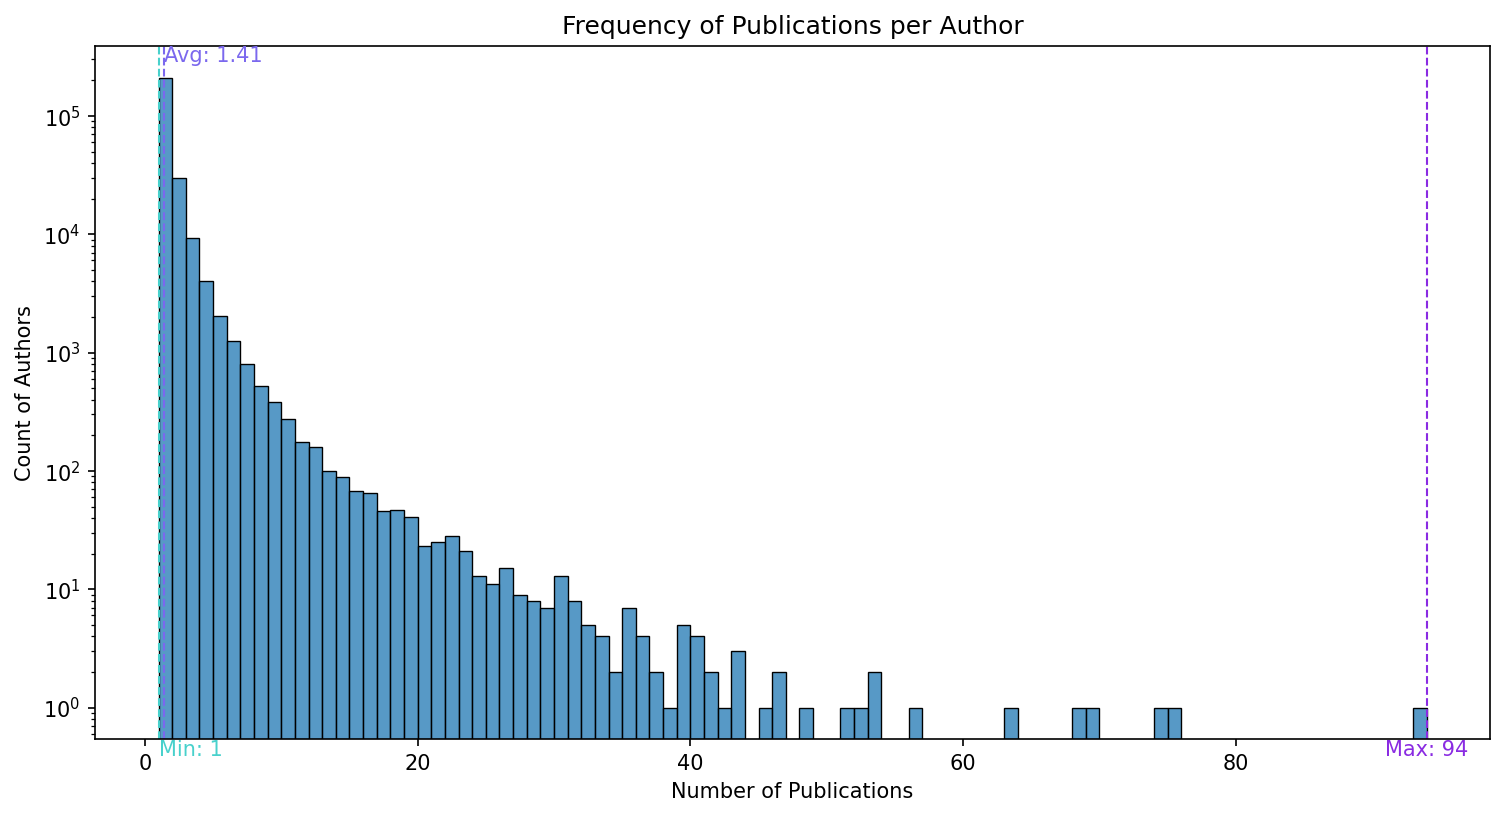

/var/folders/ll/bb9p31ws1bq30rs5vh03t4f80000gn/T/ipykernel_35810/2952677862.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Publications', y='Author', data=top_authors, palette='Purples_r')


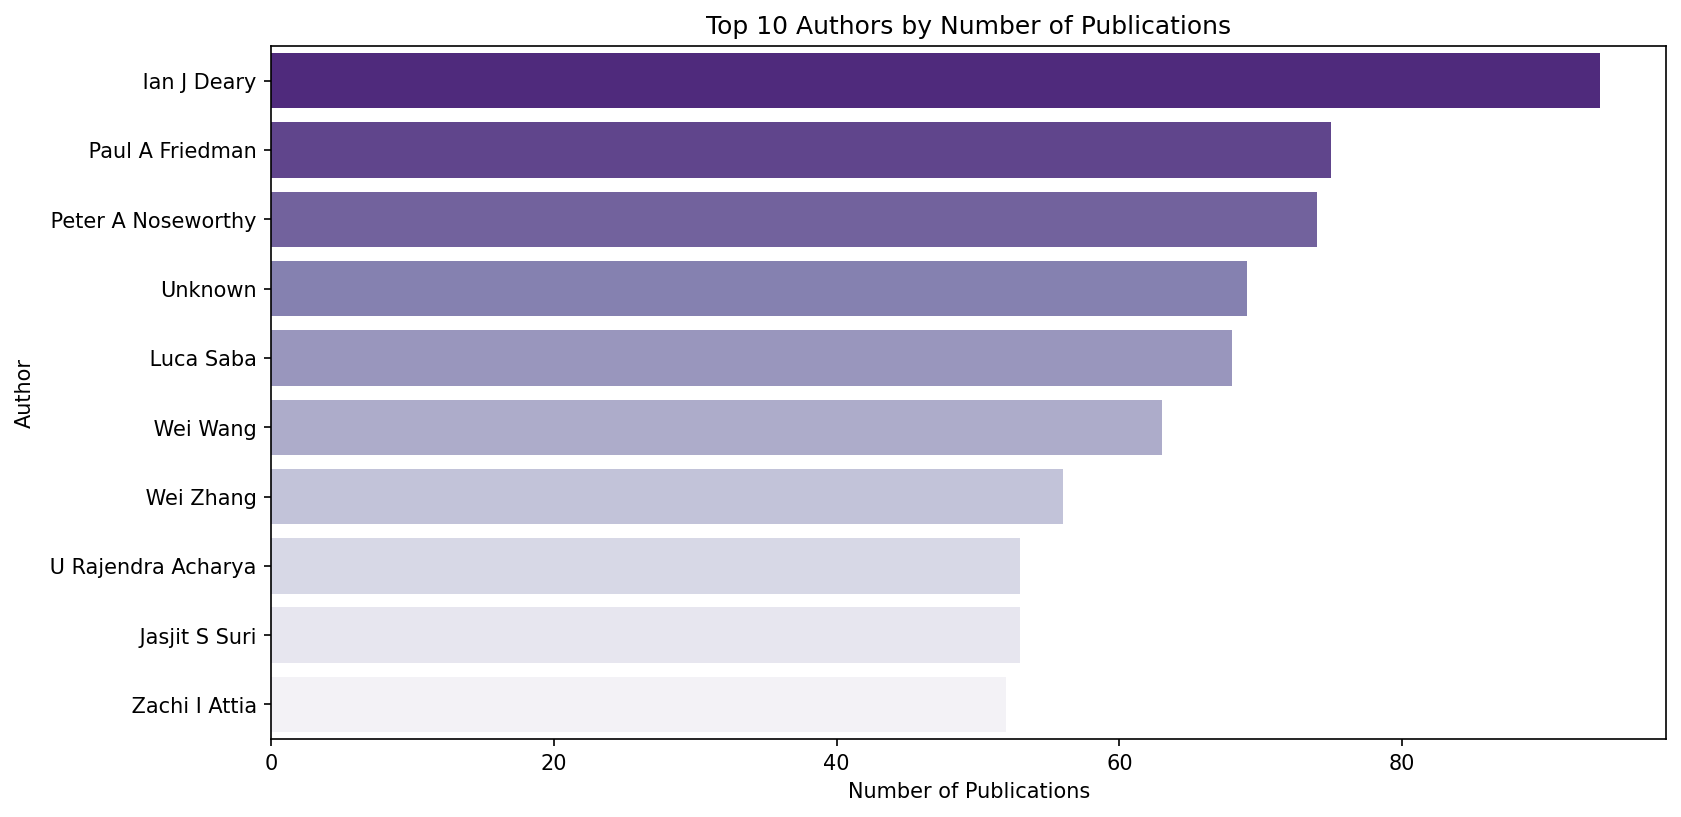

In [89]:
# Plot authors according to their number of contributions

# Split the string of authors into individual authors and flatten the list
all_authors = df['Authors'].str.split(';').explode()

# Count the number of publications for each author
author_counts = all_authors.value_counts()

# Calculate average, min, and max
average_publications = author_counts.mean()
min_publications = author_counts.min()
max_publications = author_counts.max()

# Frequency of Publications per Author
plt.figure(figsize=(12, 6), dpi=150)
sns.histplot(author_counts, bins=range(1, author_counts.max() + 1), kde=False)
plt.title('Frequency of Publications per Author')
plt.xlabel('Number of Publications')
plt.ylabel('Count of Authors')
plt.yscale('log')  # Using log scale due to the distribution of publication counts

# Annotate the average, min, and max on the plot
# The y coordinate is negative to place the annotation below the x-axis
plt.axvline(average_publications, color='mediumslateblue', linestyle='dashed', linewidth=1)
plt.text(average_publications, plt.ylim()[1], f'Avg: {average_publications:.2f}', color='mediumslateblue', ha="left", va="top")
plt.axvline(min_publications, color='mediumturquoise', linestyle='dashed', linewidth=1)
plt.text(min_publications, plt.ylim()[0], f'Min: {min_publications}', color='mediumturquoise', ha="left", va="top")
plt.axvline(max_publications, color='blueviolet', linestyle='dashed', linewidth=1)
plt.text(max_publications, plt.ylim()[0], f'Max: {max_publications}', color='blueviolet', ha="center", va="top")

# Save plot
plt.savefig("../docs/images/distribution_authors_frequency_contribution.png")
plt.show()


# Top 10 Authors by Number of Contributions
# Get the top 10 authors by publication count
top_authors = author_counts.head(10).reset_index()
top_authors.columns = ['Author', 'Publications']

# This bar plot shows the top 10 authors by their number of publications.
plt.figure(figsize=(12, 6), dpi=150)
sns.barplot(x='Publications', y='Author', data=top_authors, palette='Purples_r')
plt.title('Top 10 Authors by Number of Publications')
plt.xlabel('Number of Publications')
plt.ylabel('Author')

plt.savefig("../docs/images/distribution_authors_most_frequent.png")
plt.show()

In [95]:
# Model topics based on titles
# Lowercasing and removing extra whitespace
titles = df['Title'].str.lower().str.replace(r'\s+', ' ', regex=True)
titles = df['Title'].tolist()

# Create a BERTopic model
topic_model = BERTopic(verbose=True)
#topic_model = BERTopic(nr_topics="auto")  # 'auto' lets the model determine the number of topics

# Fit model to our data
topics, probabilities = topic_model.fit_transform(titles[:100])

# Reduce or expand the number of topics
#topic_model.update_topics(titles, topics, nr_topics=10)

# Get overview of generated topics
topic_model.get_topic_info()

2024-02-15 20:41:44,524 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 4/4 [00:00<00:00, 14.89it/s]
2024-02-15 20:41:44,917 - BERTopic - Embedding - Completed ✓
2024-02-15 20:41:44,917 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-15 20:41:45,836 - BERTopic - Dimensionality - Completed ✓
2024-02-15 20:41:45,837 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-15 20:41:45,841 - BERTopic - Cluster - Completed ✓
2024-02-15 20:41:45,843 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-15 20:41:45,849 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,47,-1_and_of_in_the,"[and, of, in, the, with, performance, intelligence, an, for, to]","[Latent class analysis of reading, decoding, and writing performance using the Academic Performance Test: concurrent and discriminating validity., The relationship between emotional intelligence and academic stress in students of medical sciences., The relationship between spiritual intelligence with psychological well-being and purpose in life of nurses.]"
1,0,36,0_of_in_and_children,"[of, in, and, children, the, with, intelligence, study, syndrome, schizophrenia]","[The use of nouns and verbs by children with Down syndrome in two different situations., Predictors of intelligence at the age of 5: family, pregnancy and birth characteristics, postnatal influences, and postnatal growth., The association between intelligence scores and family history of psychiatric disorder in schizophrenia patients, their siblings and healthy controls.]"
2,1,17,1_on_of_the_and,"[on, of, the, and, in, artificial, reward, based, learning, by]","[Bio-robots automatic navigation with graded electric reward stimulation based on Reinforcement Learning., Ratbot automatic navigation by electrical reward stimulation based on distance measurement in unknown environments., On the relationships between generative encodings, regularity, and learning abilities when evolving plastic artificial neural networks.]"


In [107]:
# Let's assume you have a DataFrame 'df' with a column 'Title' for titles of publications.
# Preprocess the titles
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([word for word in doc.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

titles_clean = [clean(doc).split() for doc in df['Title']]  # Assuming the title column is named 'Title'

# Create a dictionary and corpus
dictionary = corpora.Dictionary(titles_clean)
corpus = [dictionary.doc2bow(text) for text in titles_clean]

# Run LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word = dictionary, passes=15)

# Print the topics
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.030*"intelligence" + 0.018*"study" + 0.017*"ai" + 0.015*"chatgpt" + 0.014*"health" + 0.012*"medical" + 0.010*"emotional" + 0.009*"healthcare" + 0.009*"language" + 0.009*"model"')
(1, '0.014*"child" + 0.014*"cognitive" + 0.011*"study" + 0.009*"disorder" + 0.009*"patient" + 0.008*"adult" + 0.008*"brain" + 0.008*"outcome" + 0.007*"association" + 0.007*"effect"')
(2, '0.038*"learning" + 0.029*"artificial" + 0.025*"using" + 0.020*"machine" + 0.019*"deep" + 0.019*"intelligence" + 0.015*"model" + 0.015*"cancer" + 0.013*"detection" + 0.012*"network"')
(3, '0.055*"artificial" + 0.045*"intelligence" + 0.023*"review" + 0.013*"application" + 0.011*"system" + 0.010*"future" + 0.010*"research" + 0.009*"data" + 0.009*"clinical" + 0.008*"systematic"')


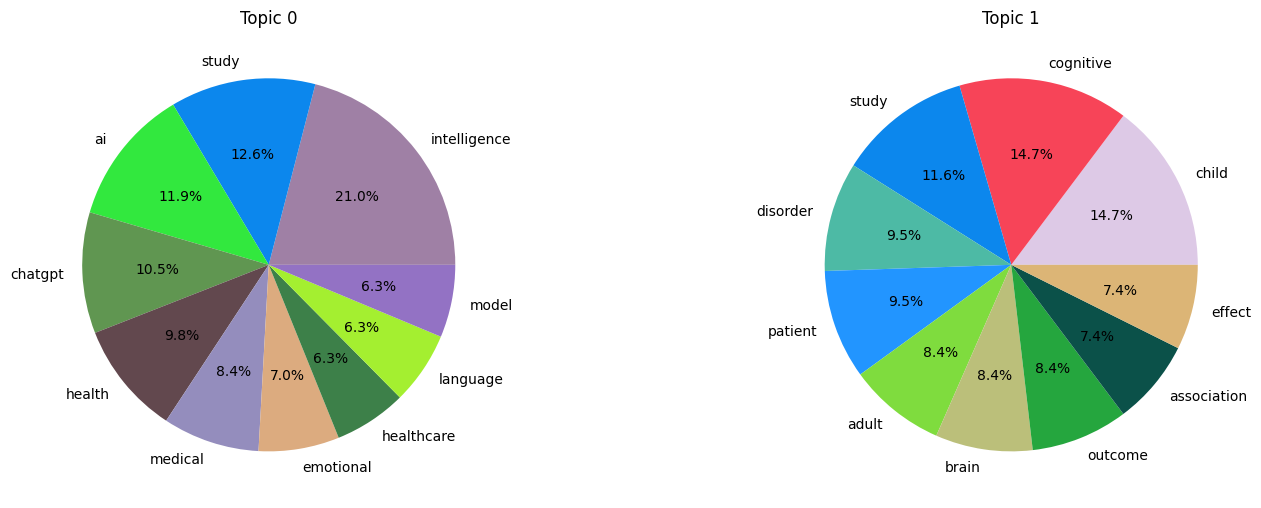

In [119]:

# Define the topics with their corresponding words and probabilities
topics = [
    [("intelligence", 0.030), ("study", 0.018), ("ai", 0.017), ("chatgpt", 0.015), ("health", 0.014), ("medical", 0.012), ("emotional", 0.010), ("healthcare", 0.009), ("language", 0.009), ("model", 0.009)],
    [("child", 0.014), ("cognitive", 0.014), ("study", 0.011), ("disorder", 0.009), ("patient", 0.009), ("adult", 0.008), ("brain", 0.008), ("outcome", 0.008), ("association", 0.007), ("effect", 0.007)],
    #[("learning", 0.038), ("artificial", 0.029), ("using", 0.025), ("machine", 0.020), ("deep", 0.019), ("intelligence", 0.019), ("model", 0.015), ("cancer", 0.015), ("detection", 0.013), ("network", 0.012)],
    #[("artificial", 0.055), ("intelligence", 0.045), ("review", 0.023), ("application", 0.013), ("system", 0.011), ("future", 0.010), ("research", 0.010), ("data", 0.009), ("clinical", 0.009), ("systematic", 0.008)]
]

# Assign colors to words consistently across all charts
color_map = {}
for topic in topics:
    for word, _ in topic:
        if word not in color_map:
            color_map[word] = f'#{hashlib.sha256(word.encode()).hexdigest()[:6]}'  # Generate a unique color for each word

# Create a pie chart for each topic
plt.figure(figsize=(15, 10))
for i, topic in enumerate(topics):
    words, probs = zip(*topic)
    colors_assigned = [color_map[word] for word, _ in topic]  # Assign consistent colors to words
    plt.subplot(2, 2, i+1)  # Adjusted to 2x2 grid
    plt.pie(probs, labels=words, colors=colors_assigned, autopct='%1.1f%%')
    plt.title(f'Topic {i}')

plt.tight_layout()
plt.savefig("../docs/images/topics_LDA.png")
plt.show()